# 1. Import Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay)

# 2. Data Loading

In [2]:
df = pd.read_csv("breast-cancer.csv")

# 3. Data Exploration

In [3]:
def shapes_vars(df, df_name):
  print(f'The {df_name} data frame has {df.shape[0]} records and {df.shape[1]} variables. The names and types of these variables are:\n{df.dtypes}')

In [4]:
shapes_vars(df, 'df')

The df data frame has 569 records and 32 variables. The names and types of these variables are:
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 fl

# 4. Checking of Duplicates & Missingness


In [5]:
def duplicates_missingness(df, df_name):
  n_duplicates = df.duplicated().sum()
  perc_duplicates = n_duplicates/df.shape[0]*100
  n_cells = np.prod(df.shape)
  n_missing = df.isna().sum().sum()
  perc_missing = n_missing/n_cells*100

  if n_duplicates == 0 and n_missing == 0:
    print(f'The {df_name} data frame has no duplicates and no missing values.')
  elif n_duplicates != 0 and n_missing == 0:
    print(f'The {df_name} data frame has no missing cells but {n_duplicates} duplicates of percentage {perc_duplicates:.3f}%.')
  elif n_duplicates == 0 and n_missing != 0:
    print(f'The {df_name} data frame has no duplicates but {n_missing} missing values of percentage {perc_missing}%.')
  elif n_duplicates != 0 and n_missing != 0:
    print(f'The {df_name} data frame has {n_duplicates} duplicates of percentage {perc_duplicates:.3f}% and {n_missing} missing values of percentage {perc_missing}%.')

  if n_missing == 0:
    cols_w_miss = [col for col in df.columns if df[col].isna().sum() != 0]
    n_miss = [df[col].isna().sum() for col in cols_w_miss]
    perc_miss = [round(x/df.shape[0]*100, 3) for x in n_miss]

    duplicates_missingness_df = pd.DataFrame({
        'feature': cols_w_miss,
        'n_missing': n_miss,
        'perc_missing': perc_miss}).set_index('feature').sort_values(by = 'n_missing', ascending = False)
    return duplicates_missingness_df

  else:
    return None

In [6]:
duplicates_missingness(df, 'df')

The df data frame has no duplicates and no missing values.


,n_missing,perc_missing
feature,,


# 5. Data Splitting

In [7]:
SEED = 42

In [10]:
X = df.drop(['diagnosis', 'id'], axis = 1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

features = [X_train, X_test]
targets = [y_train, y_test]
sets_names = ['Training', 'Test']

for set_name, feature, target in zip(sets_names, features, targets):
  print(f'For the {set_name} Set:\n\t- Size of the Features: {feature.shape}.\n\t- Shape of the Target Variable: {target.shape}')

For the Training Set:
	- Size of the Features: (455, 30).
	- Shape of the Target Variable: (455,)
For the Test Set:
	- Size of the Features: (114, 30).
	- Shape of the Target Variable: (114,)


# 6. Training Set Exploration

In [11]:
train = pd.concat([X_train, y_train], axis = 1)
palette = sns.color_palette('bright')

<Axes: title={'center': 'Distribution of Diagnosis'}, xlabel='diagnosis'>

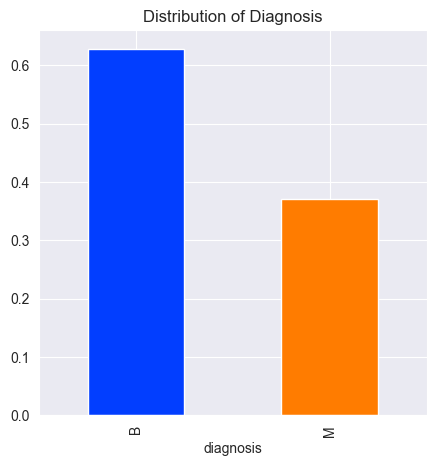

In [12]:
y_train.value_counts(normalize = True).plot(kind = 'bar', title = 'Distribution of Diagnosis', figsize = (5, 5), color = palette)

In [21]:
def plots_for_continuous(df, col):
  plt.figure(figsize = (15, 5))

  plt.subplot(1, 3, 1)
  q1, q3 = np.quantile(df[col], [.25, .75])
  iqr = q3 - q1
  lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
  n_outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
  perc_outliers = n_outliers/df.shape[0]*100
  sns.boxplot(x = df[col])
  plt.title(f'{col} - Outliers: {n_outliers} ({perc_outliers:.3f}%)')

  plt.subplot(1, 3, 2)
  skewness = df[col].skew()
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
  plt.title(f'{col} - Skewness: {skewness:.3f}')

  plt.subplot(1, 3, 3)
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)
  plt.title(f'{col} by Diagnosis')

  plt.tight_layout()
  plt.show()


C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


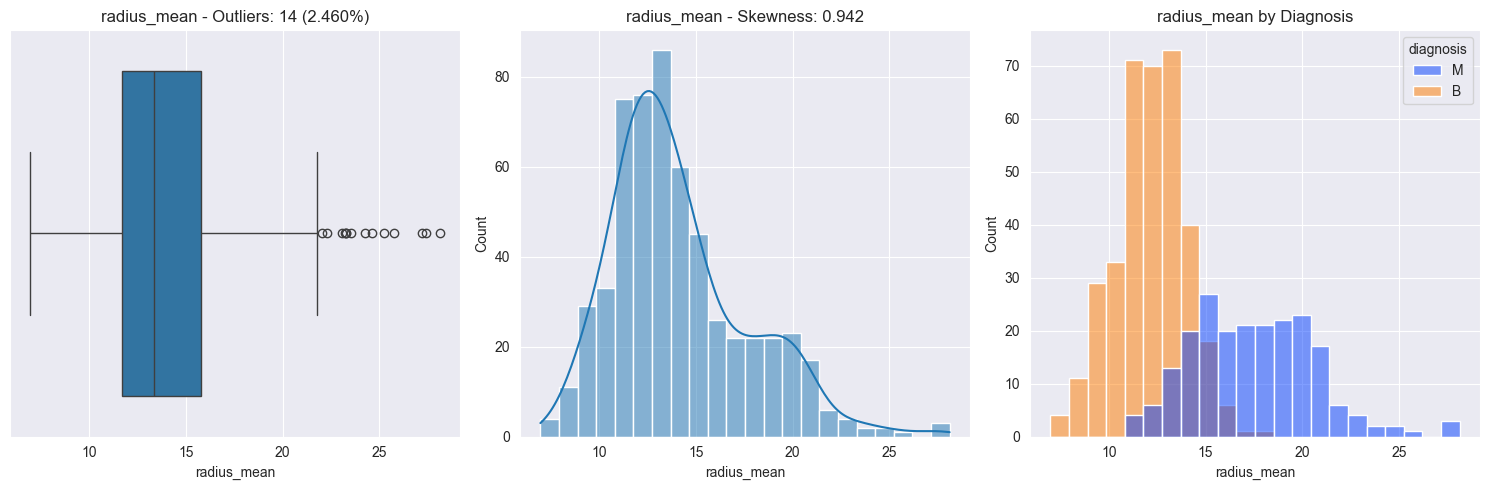

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


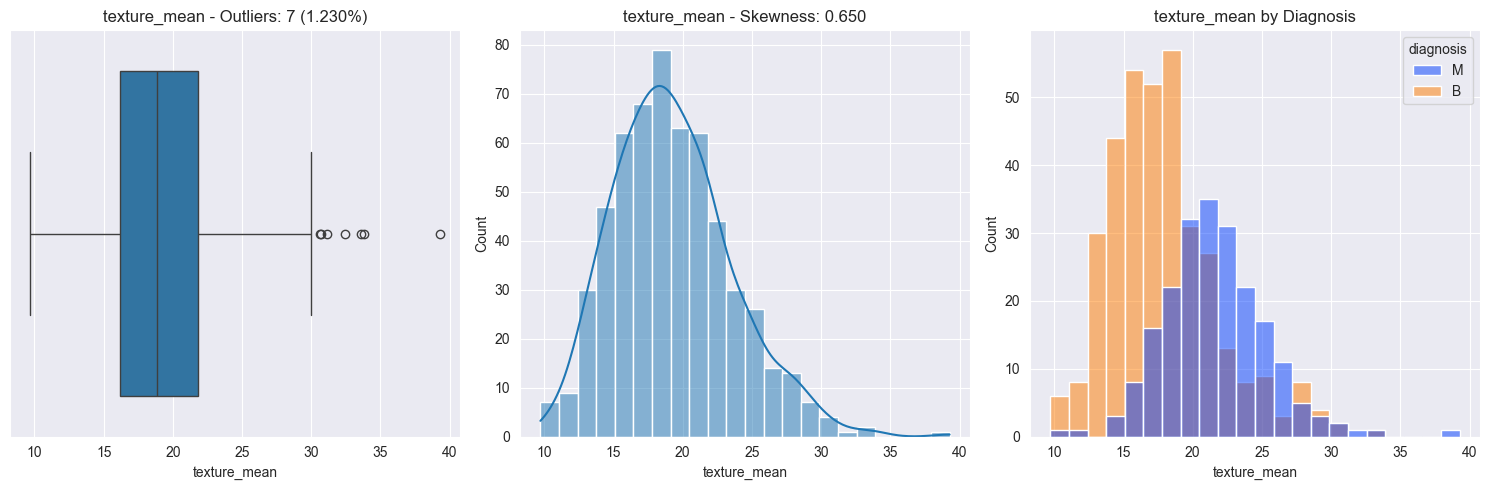

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


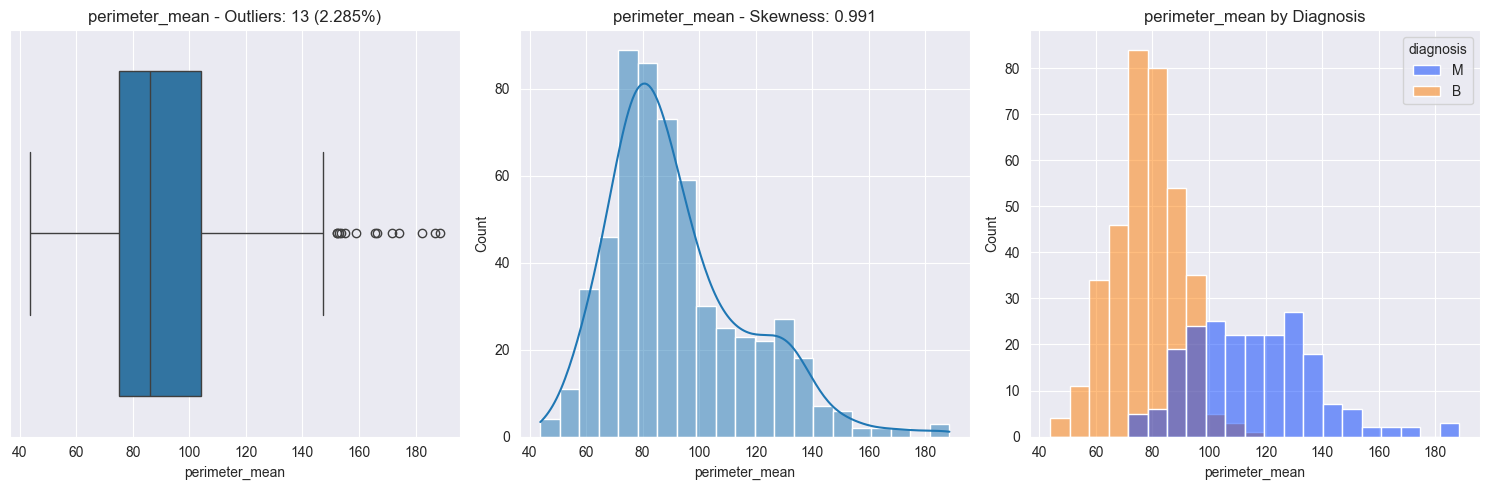

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


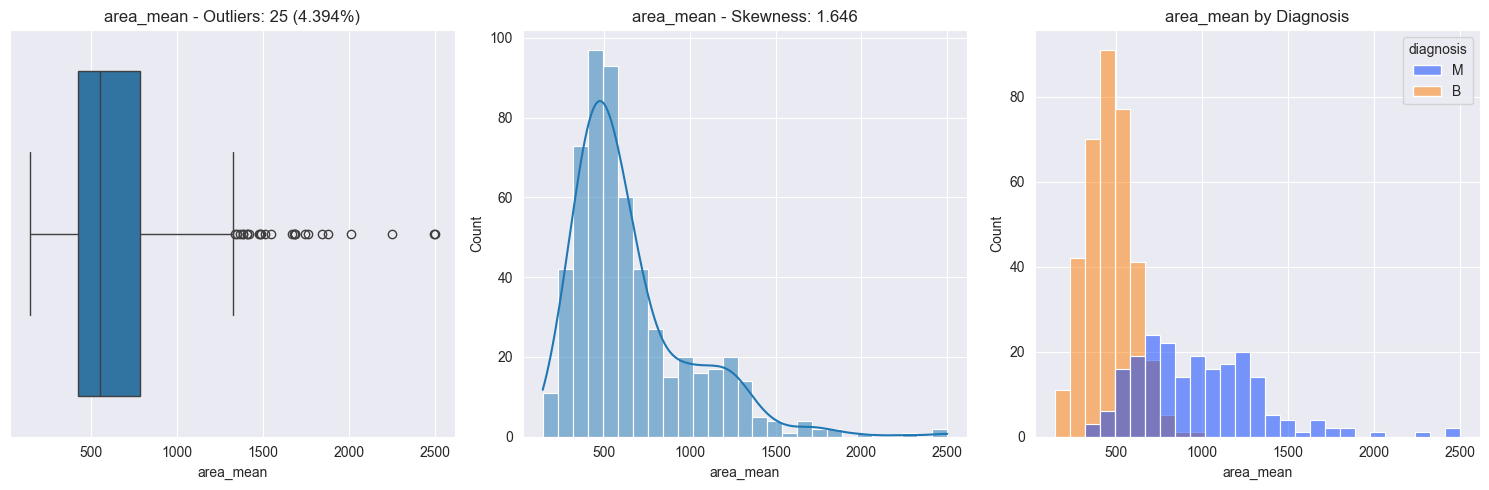

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


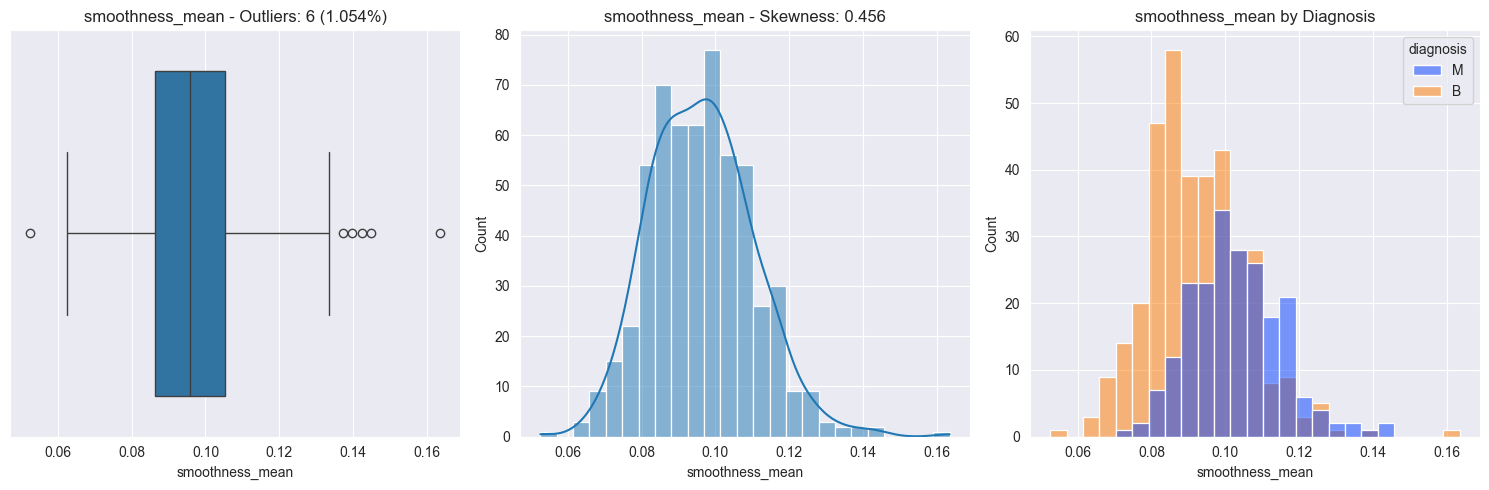

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


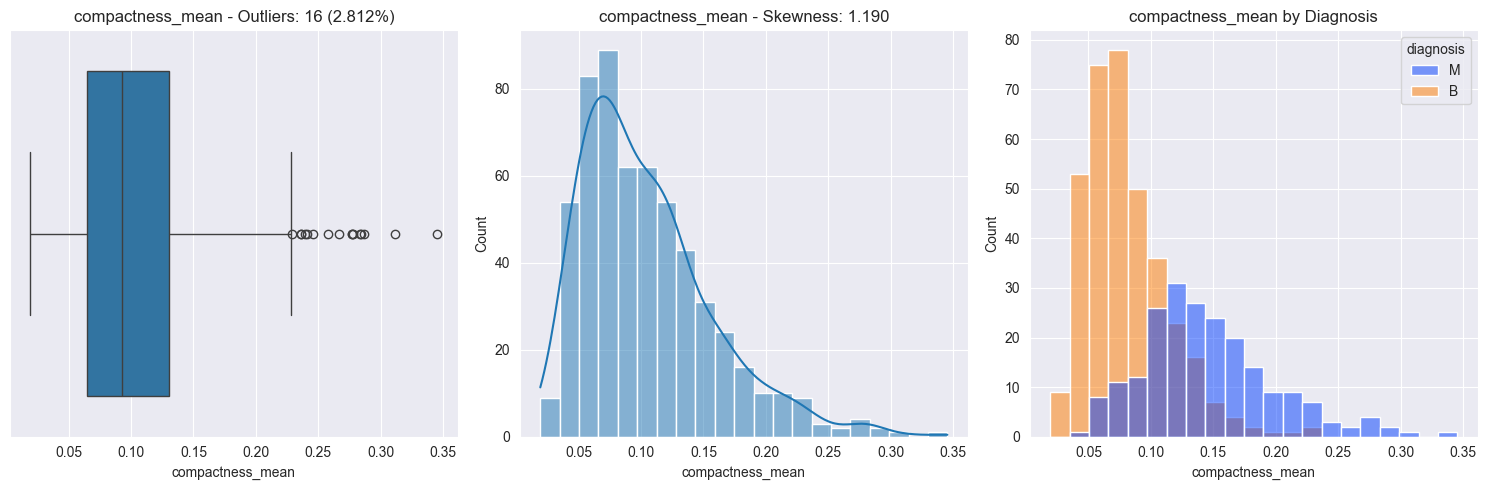

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


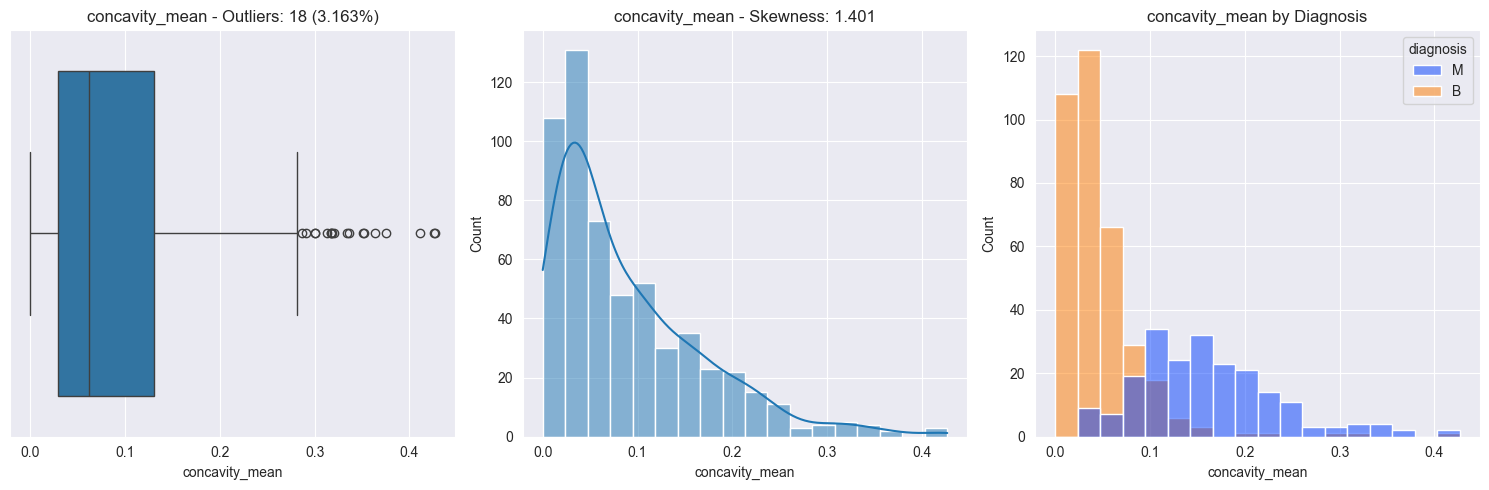

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


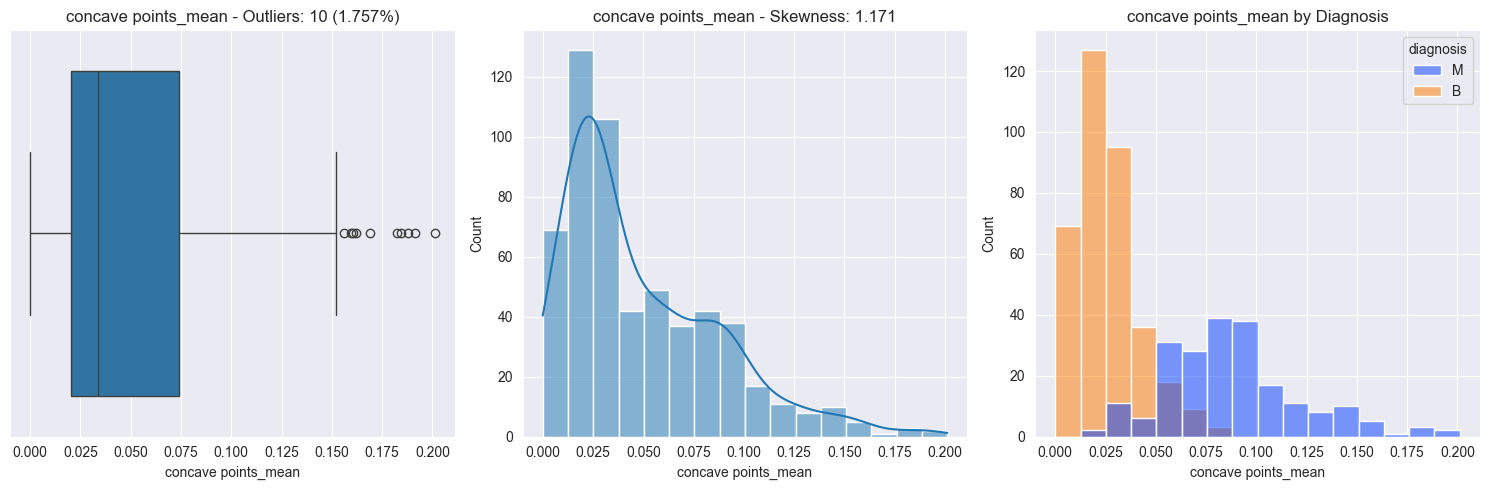

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


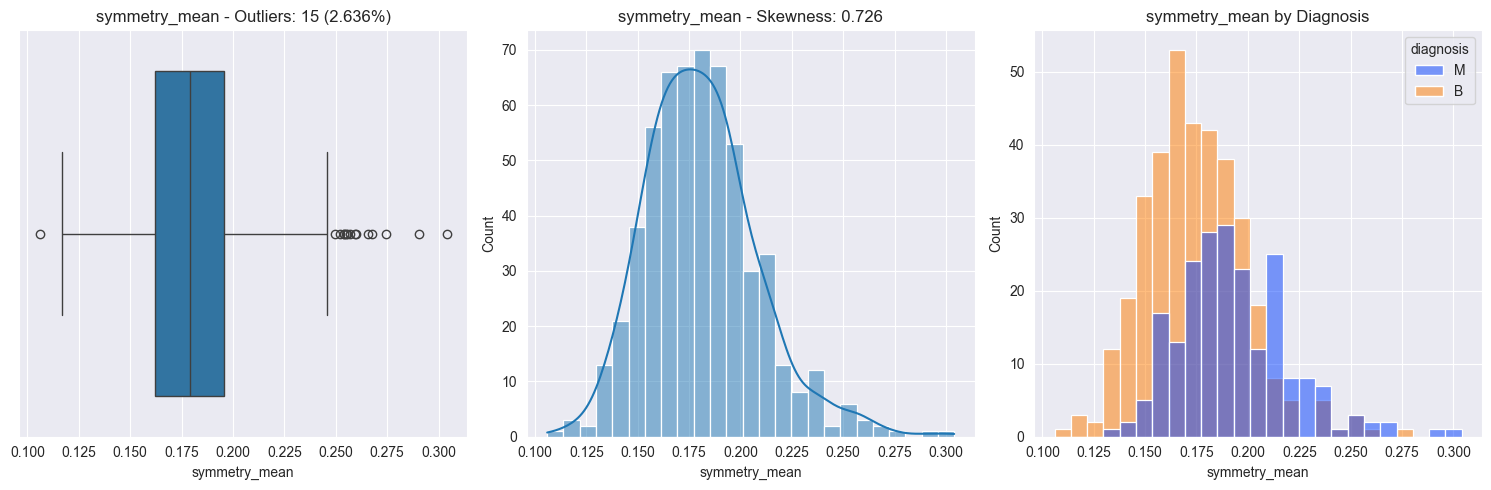

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


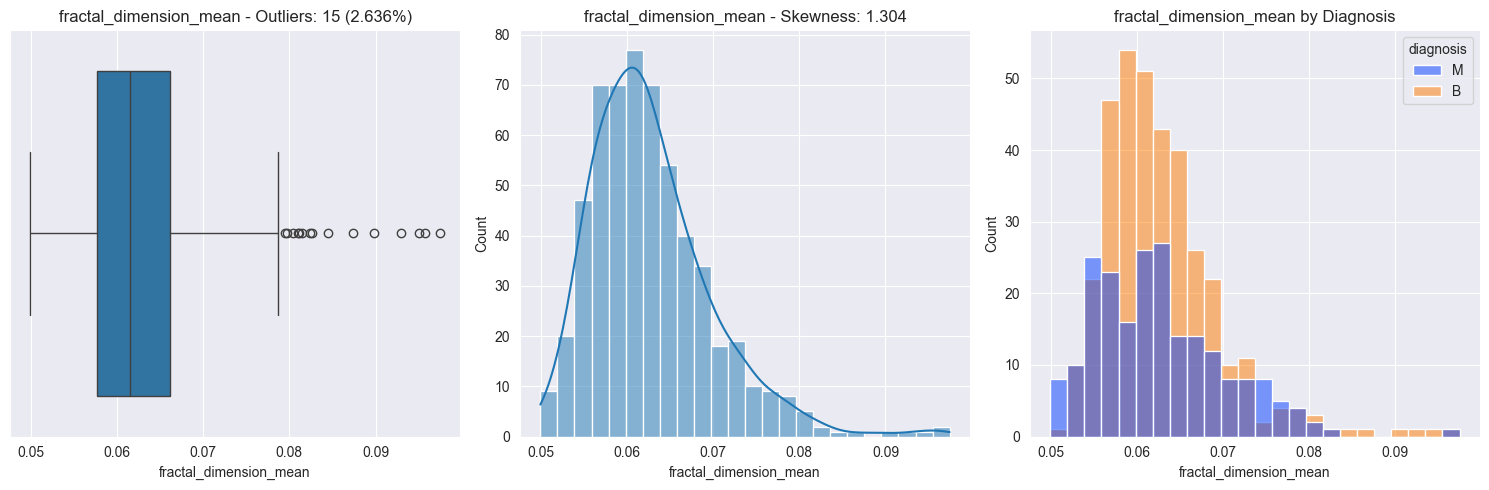

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


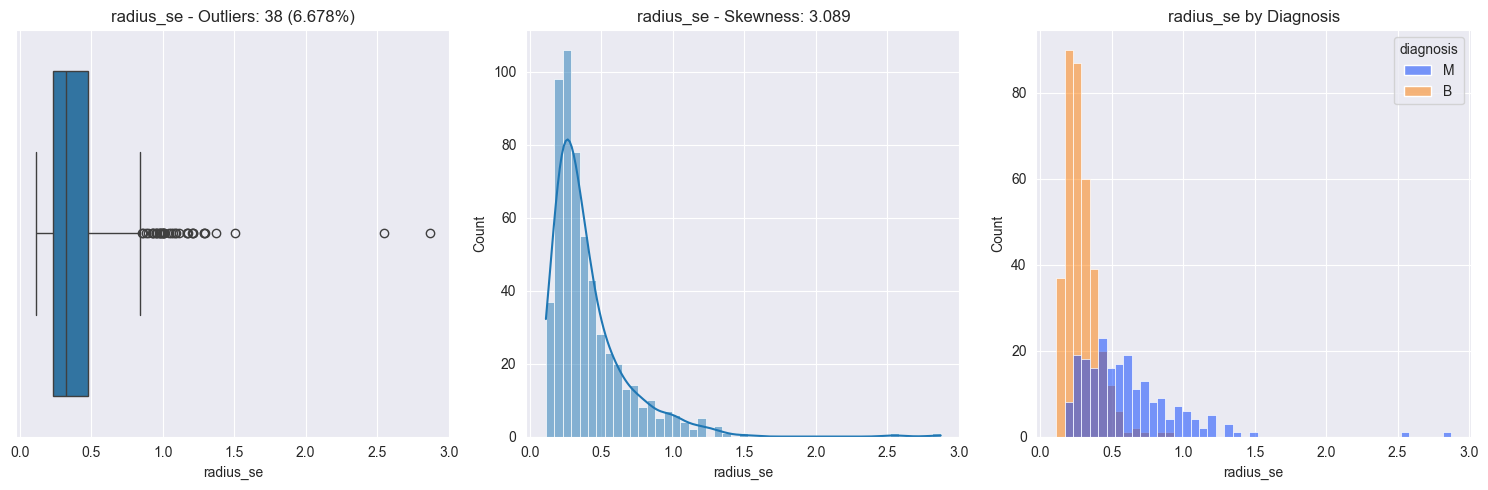

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


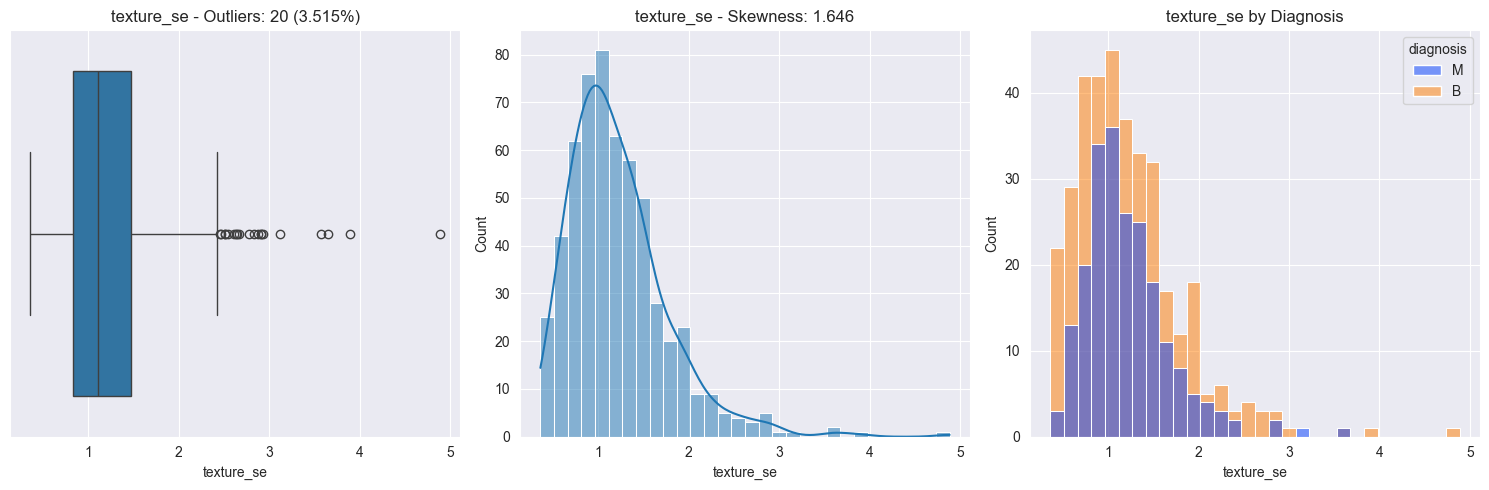

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


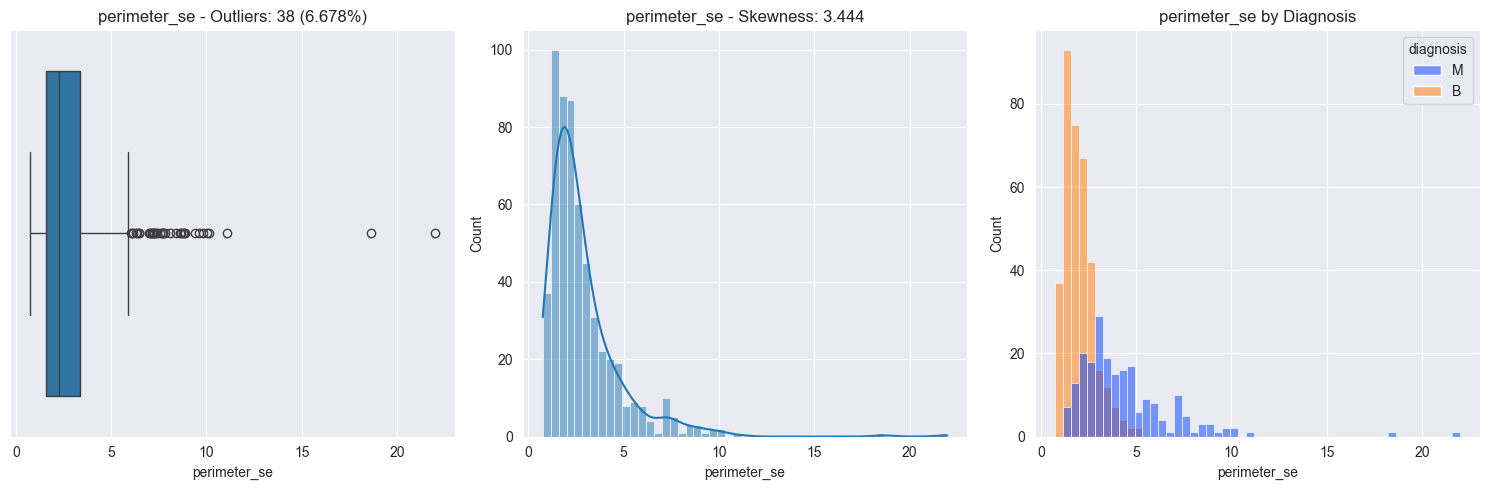

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


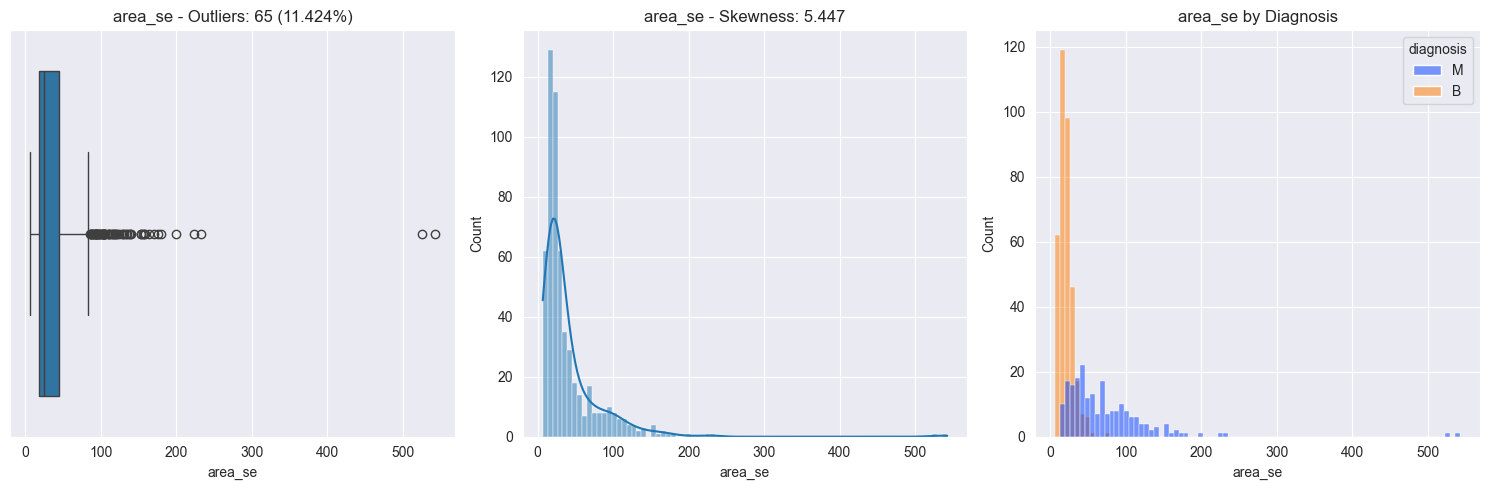

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


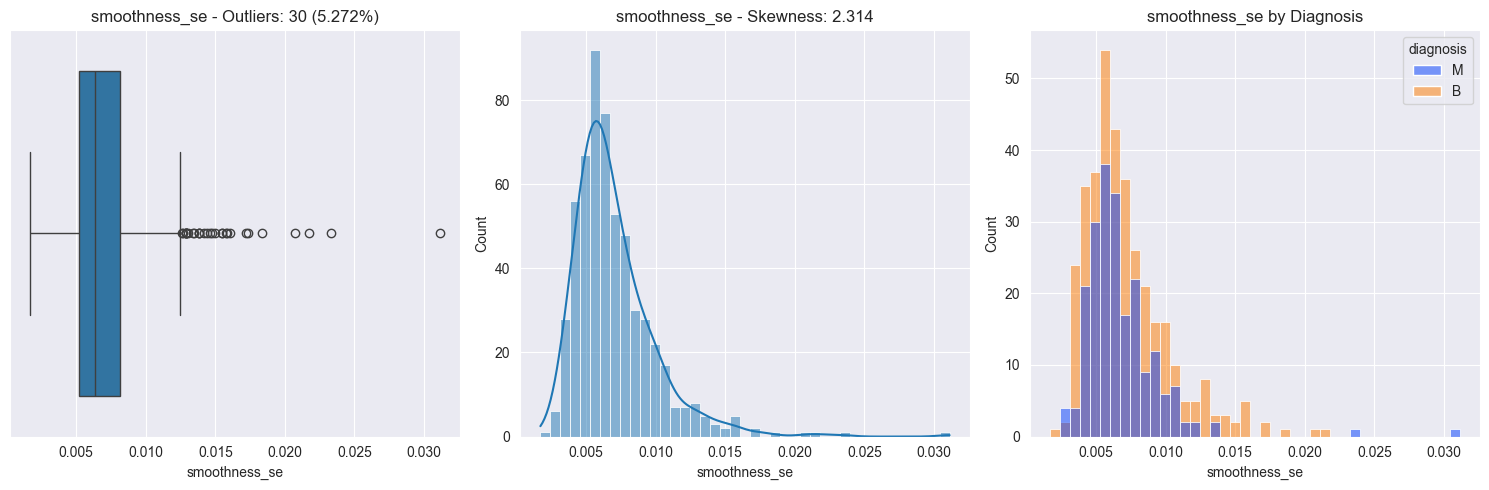

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


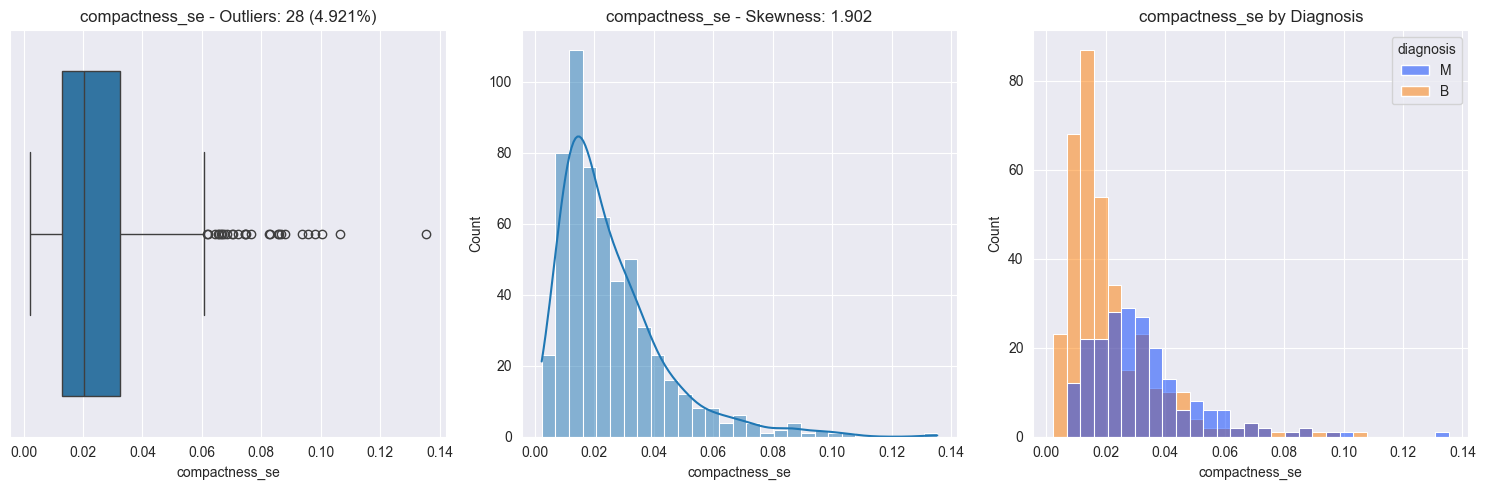

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


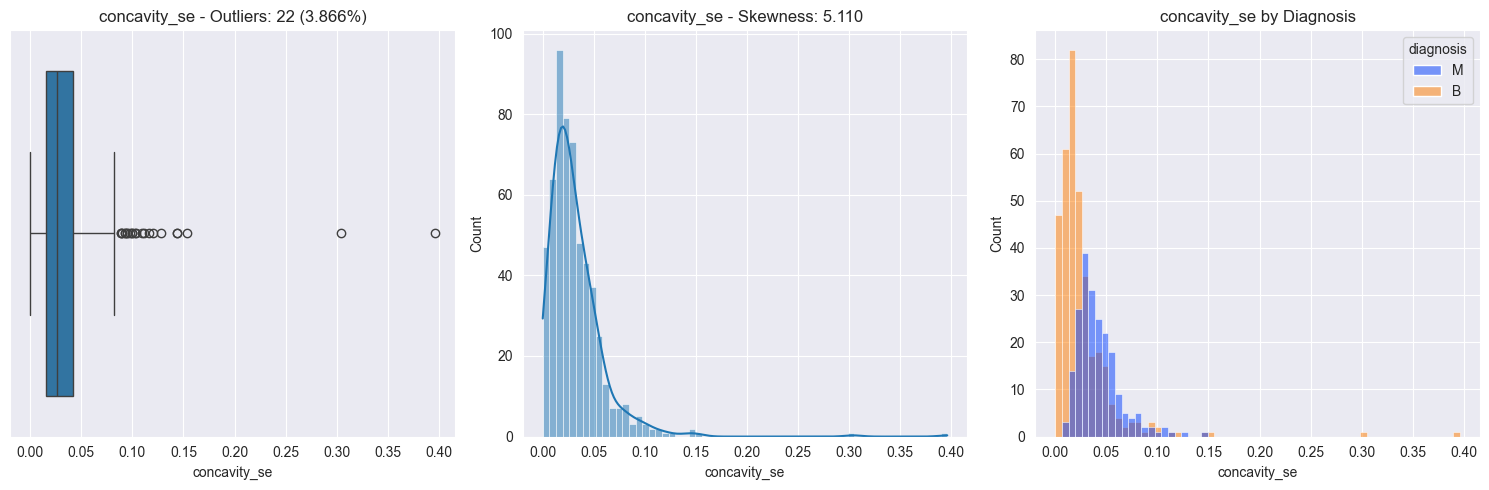

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


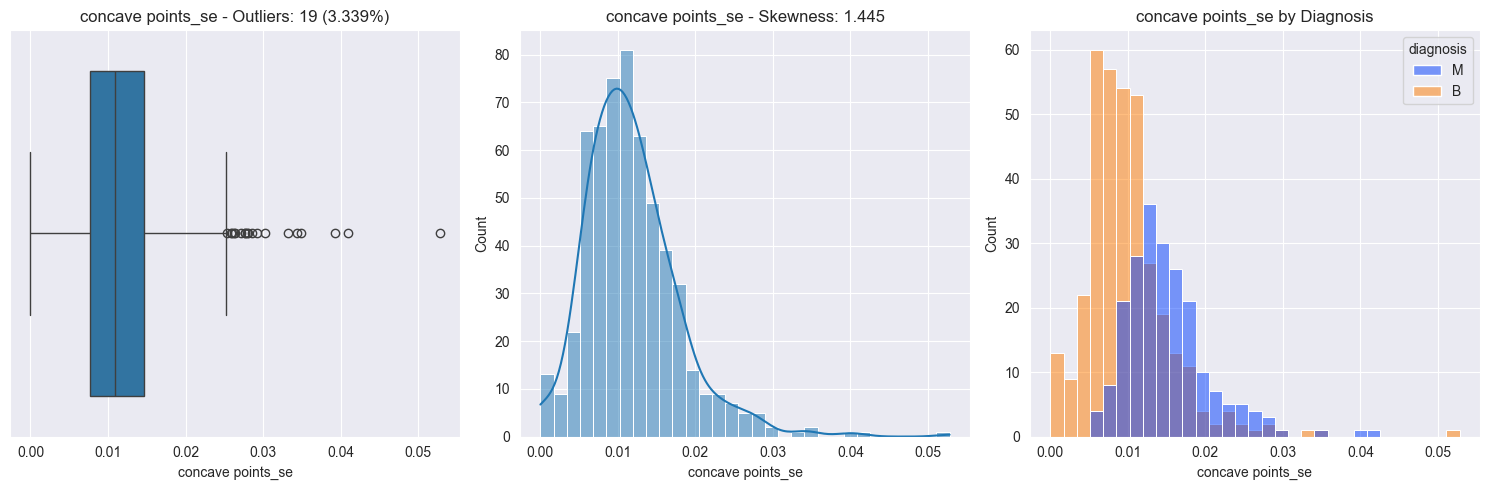

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


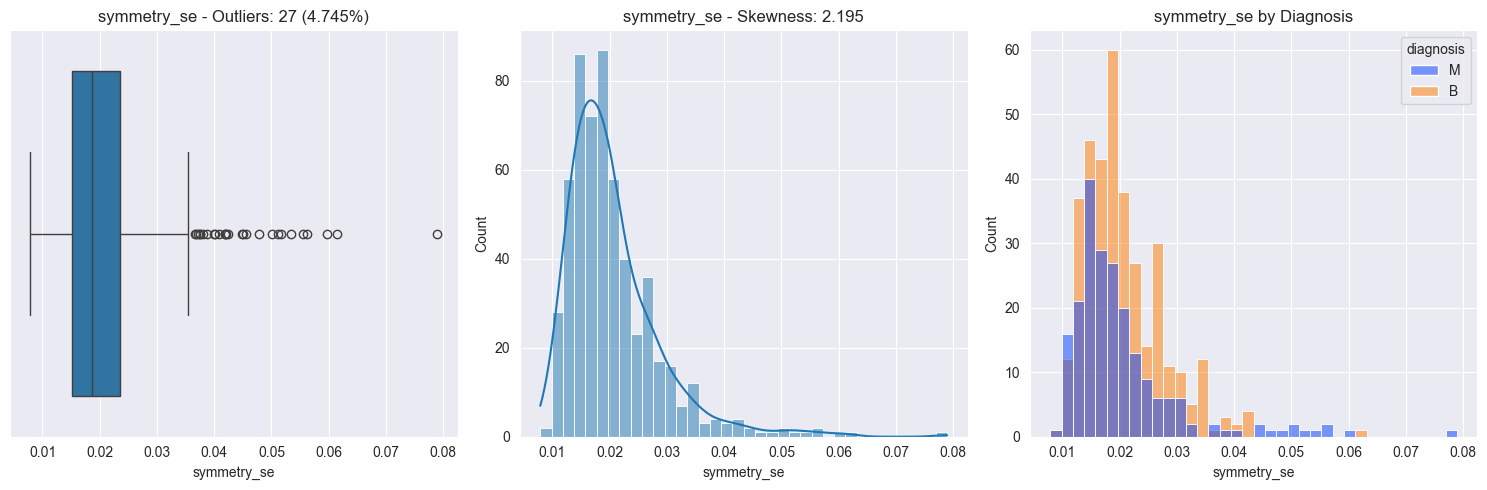

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


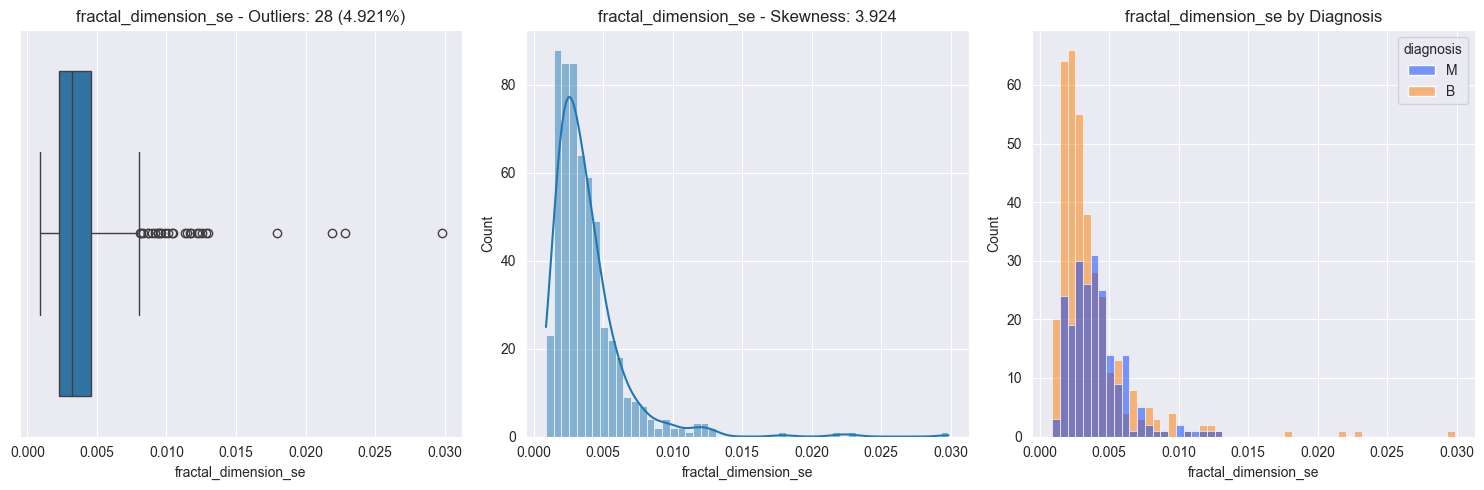

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


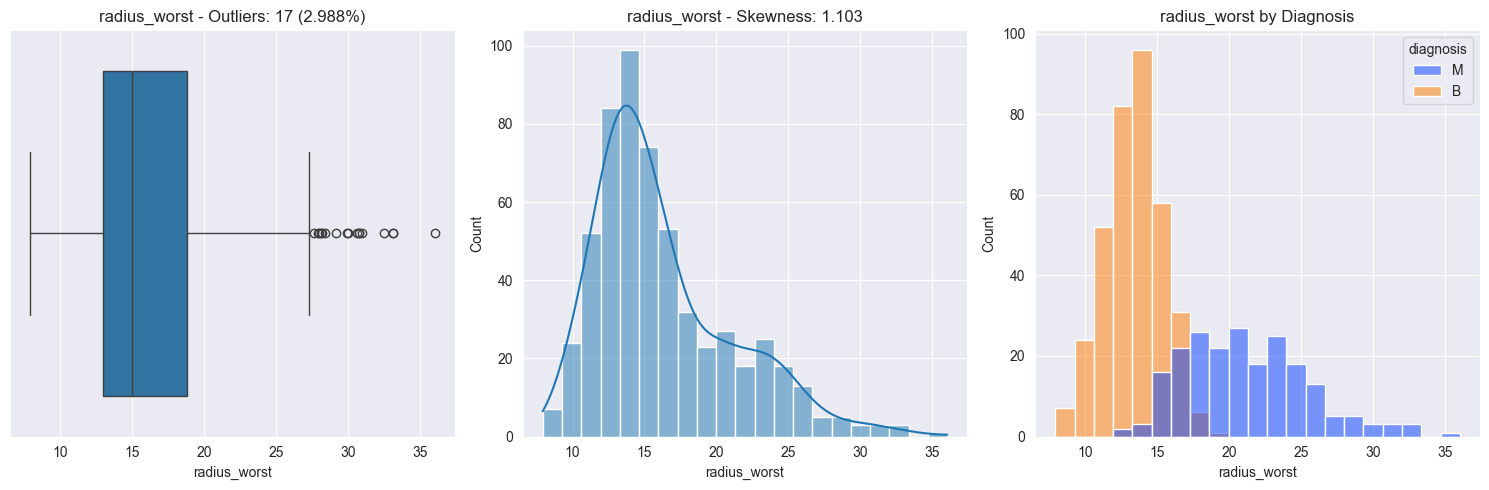

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


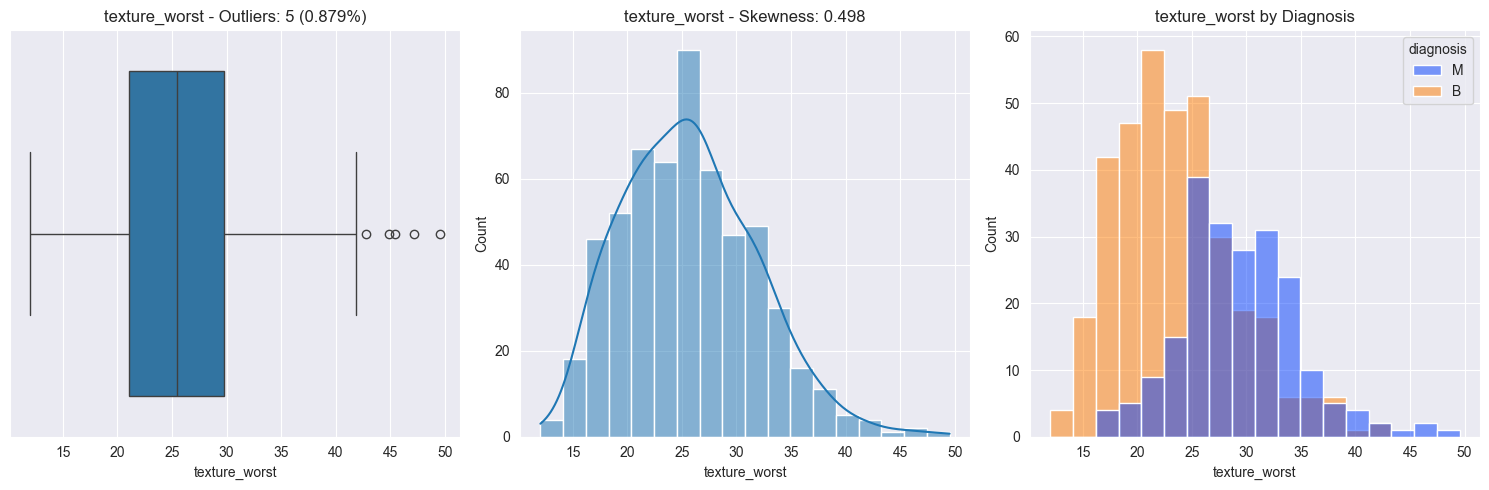

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


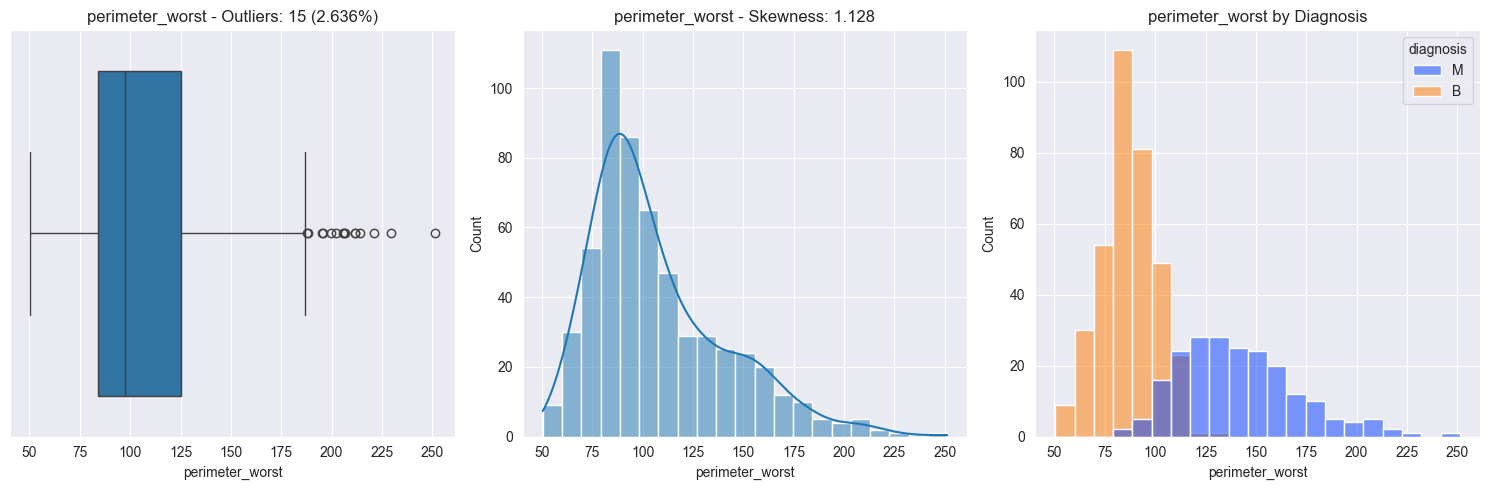

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


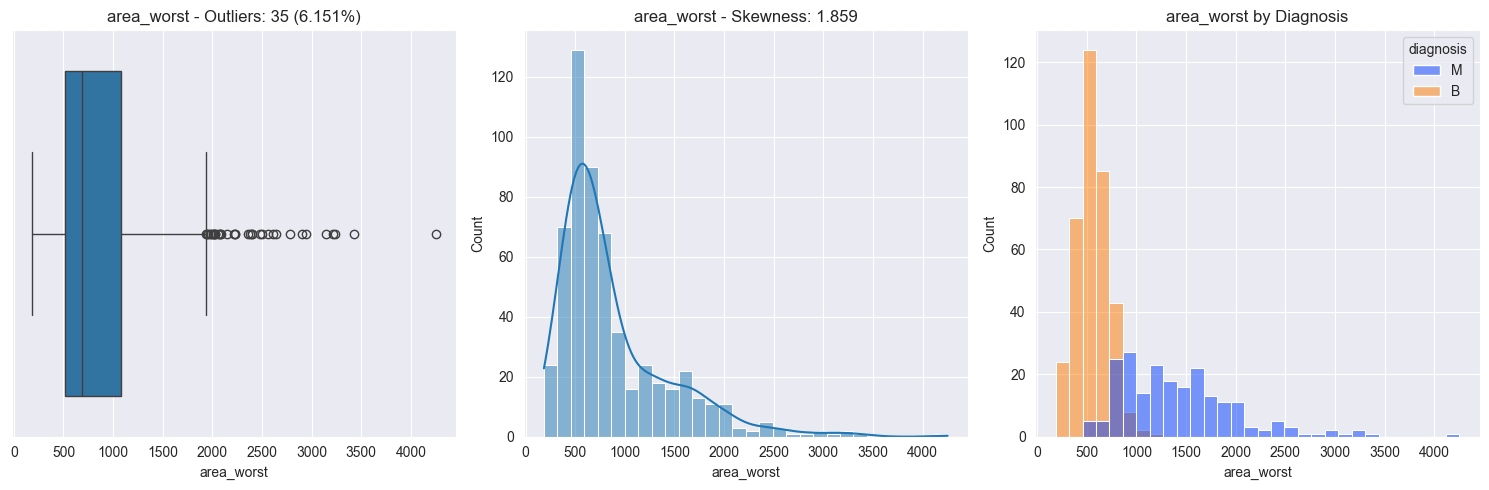

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


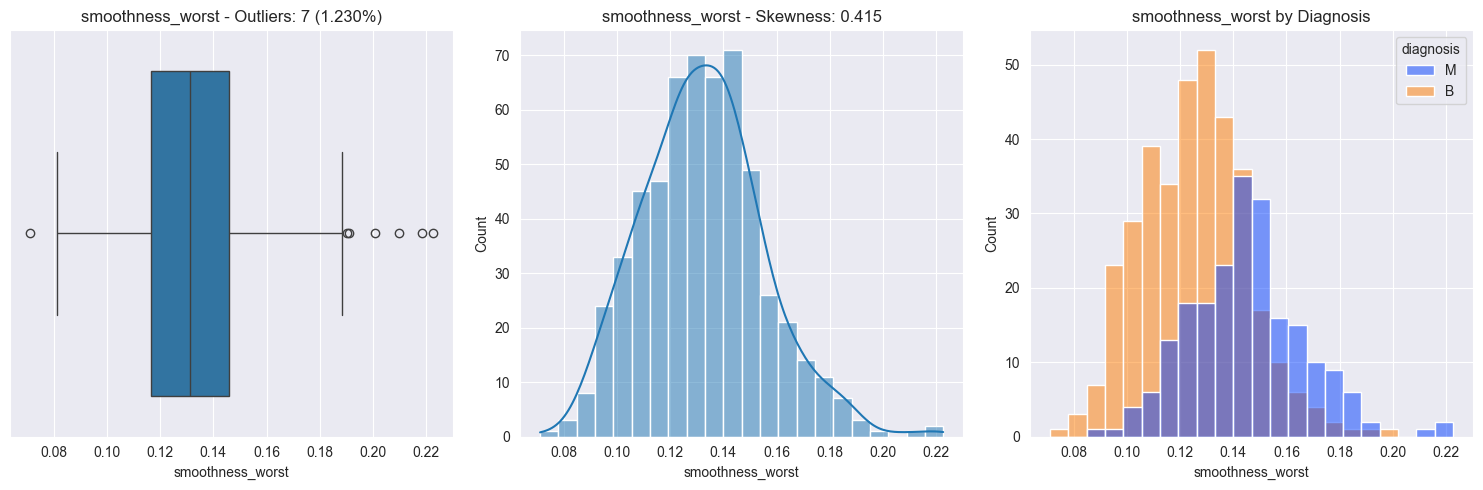

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


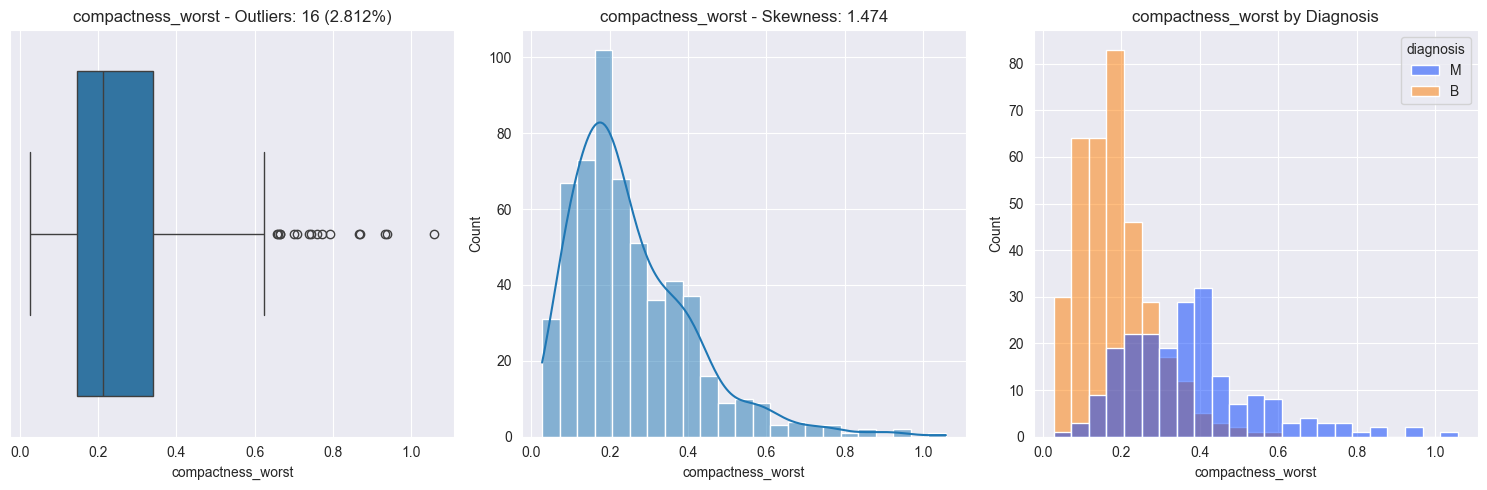

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


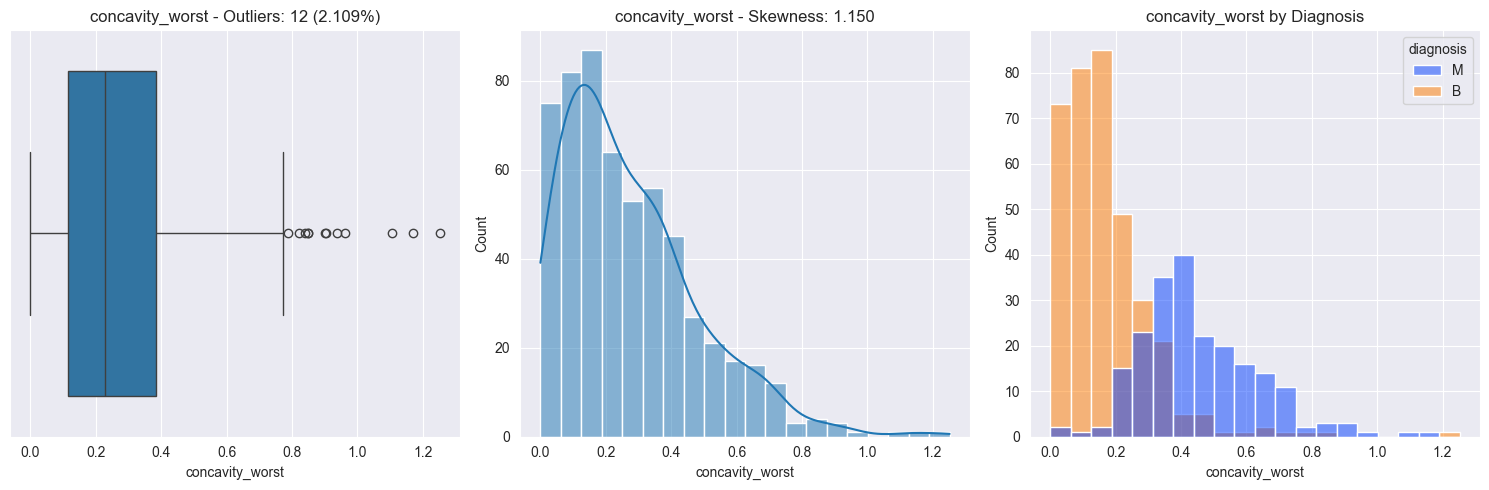

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


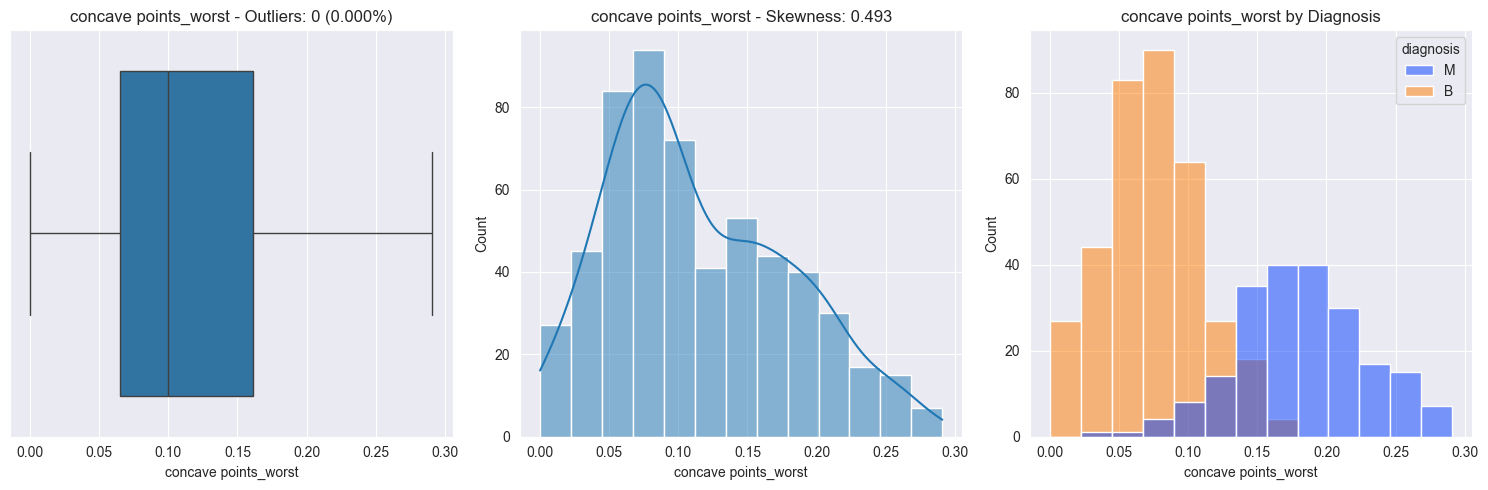

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


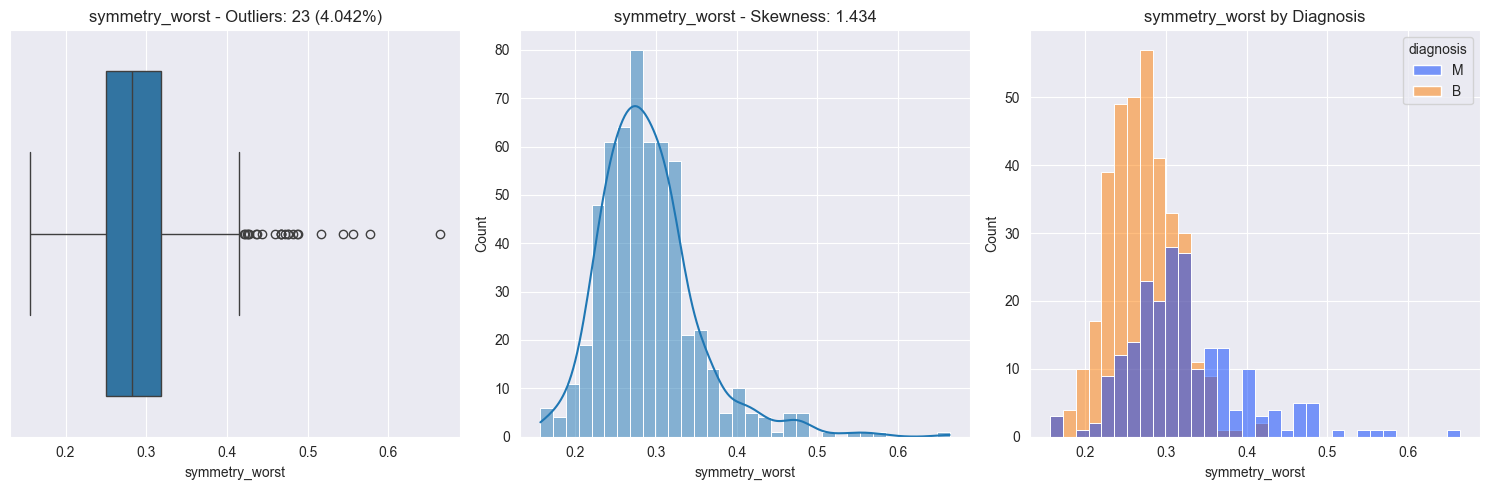

C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = df, x = col, kde = True, palette = palette[2])
C:\Users\soha\AppData\Local\Temp\ipykernel_26940\2290608817.py:19: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.histplot(data = df, x = col, hue = 'diagnosis', palette = palette)


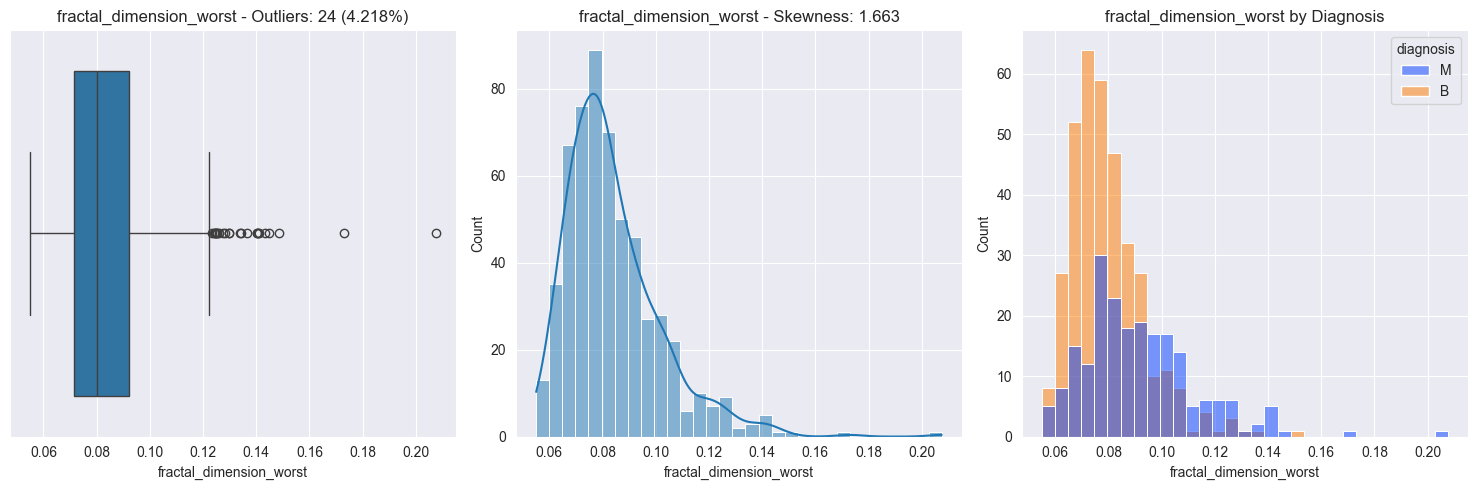

In [22]:
continuous_features = train.select_dtypes(include = 'float').columns

for col in continuous_features:
  plots_for_continuous(df, col)

# 6. Data Encoding

In [23]:
diagnosis_map = {'M': 1, 'B': 0}

y_train = y_train.map(diagnosis_map)
y_test = y_test.map(diagnosis_map)

# 7. Data Selection

In [24]:
sel_1 = VarianceThreshold(threshold = 0.01)
sel_1.fit(X_train)

features_to_drop = X_train.columns[~sel_1.get_support()]

print(f'Out of {X_train.shape[1]} variables, there are {len(features_to_drop)} features to drop for having less than 1% variance. The features are:\n{features_to_drop}.')

Out of 30 variables, there are 16 features to drop for having less than 1% variance. The features are:
Index(['smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'smoothness_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object').


In [25]:
X_train_1 = sel_1.fit_transform(X_train)
X_test_1 = sel_1.transform(X_test)

X_train_1 = pd.DataFrame(X_train_1, columns = X_train.columns[sel_1.get_support()], index = X_train.index)
X_test_1 = pd.DataFrame(X_test_1, columns = X_test.columns[sel_1.get_support()], index = X_test.index)


print(duplicates_missingness(X_train_1, 'X_train_1'))
print('\n')
print(duplicates_missingness(X_test_1, 'X_test_1'))

The X_train_1 data frame has no duplicates and no missing values.
Empty DataFrame
Columns: [n_missing, perc_missing]
Index: []


The X_test_1 data frame has no duplicates and no missing values.
Empty DataFrame
Columns: [n_missing, perc_missing]
Index: []


In [26]:
X_train_1_transposed = X_train_1.T
n_duplicated_features = X_train_1_transposed.duplicated().sum()

if n_duplicated_features == 0:
  print('There are no duplicated features.')
else:
  print(f'There are {len(n_duplicated_features)} duplicated features, which are:\n{n_duplicated_features}.')

There are no duplicated features.


<Axes: >

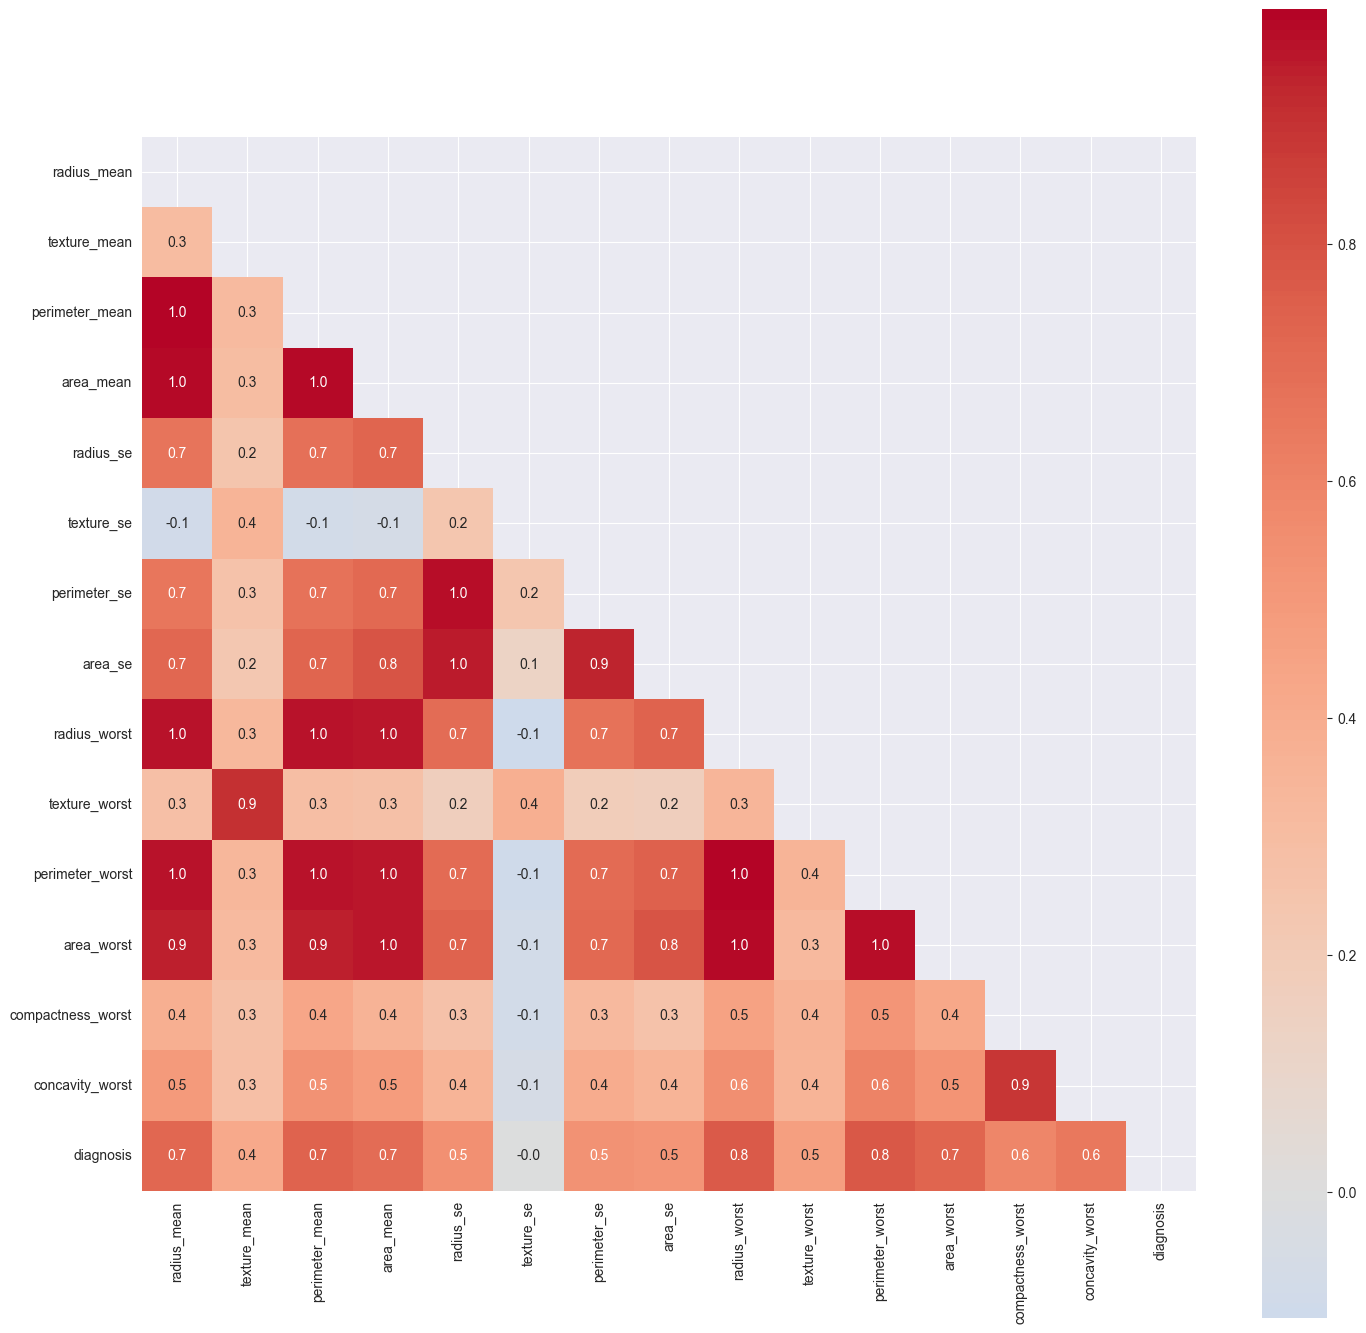

In [27]:
train_1 = pd.concat([X_train_1, y_train], axis = 1)

corr = train_1.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

plt.figure(figsize=(17, 17))

sns.heatmap(corr, mask=mask, center=0, annot=True,
            fmt='.1f', square=True, cmap='coolwarm')

In [28]:
correlated_features = set()
correlation_matrix = X_train_1.corr()

for i in range(len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i, j]) > 0.8:
      col_name = correlation_matrix.columns[i]
      correlated_features.add(col_name)

print(f'Out of {X_train_1.shape[1]} features in X_train_1, there are {len(correlated_features)} correlated features, which are:\n{correlated_features}.\n')
print(f'After removing the correlated features, the number of features becomes {X_train_1.shape[1] - len(correlated_features)}.')

Out of 14 features in X_train_1, there are 9 correlated features, which are:
{'perimeter_se', 'perimeter_worst', 'area_worst', 'perimeter_mean', 'area_se', 'radius_worst', 'area_mean', 'concavity_worst', 'texture_worst'}.

After removing the correlated features, the number of features becomes 5.


In [29]:
correlated_features = list(correlated_features)

X_train_2 = X_train_1.drop(correlated_features, axis = 1)
X_test_2 = X_test_1.drop(correlated_features, axis = 1)

print(duplicates_missingness(X_train_2, 'X_train_2'))
print('\n')
print(duplicates_missingness(X_test_2, 'X_test_2'))

The X_train_2 data frame has no duplicates and no missing values.
Empty DataFrame
Columns: [n_missing, perc_missing]
Index: []


The X_test_2 data frame has no duplicates and no missing values.
Empty DataFrame
Columns: [n_missing, perc_missing]
Index: []


# 9. ML Model Building

In [30]:
def building_classifiers(models, models_names, X_train, y_train, X_test, y_test):
    accuracy_tr, accuracy_test, precision_tr, precision_test, recall_tr, recall_test, f1_tr, f1_test, roc_auc_tr, roc_auc_test = [], [], [], [], [], [], [], [], [], []
    for model, model_name in zip(models, models_names):
        model.fit(X_train, y_train)
        y_pred_tr = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        accuracy_tr.append(round(accuracy_score(y_train, y_pred_tr), 3))
        accuracy_test.append(round(accuracy_score(y_test, y_pred_test), 3))

        precision_tr.append(round(precision_score(y_train, y_pred_tr), 3))
        precision_test.append(round(precision_score(y_test, y_pred_test), 3))

        recall_tr.append(round(recall_score(y_train, y_pred_tr), 3))
        recall_test.append(round(recall_score(y_test, y_pred_test), 3))

        f1_tr.append(round(f1_score(y_train, y_pred_tr), 3))
        f1_test.append(round(f1_score(y_test, y_pred_test), 3))

        roc_auc_tr.append(round(roc_auc_score(y_train, y_pred_tr), 3))
        roc_auc_test.append(round(roc_auc_score(y_test, y_pred_test), 3))

    classifiers_df = pd.DataFrame({
        'model': models_names,
        'accuracy_tr': accuracy_tr, 'accuracy_test': accuracy_test,
        'precision_tr': precision_tr, 'precision_test': precision_test,
        'recall_tr': recall_tr, 'recall_test': recall_test,
        'f1_tr': f1_tr, 'f1_test': f1_test,
        'roc_auc_tr': roc_auc_tr, 'roc_auc_test': roc_auc_test
    }).set_index('model').sort_values(by = ['roc_auc_test', 'roc_auc_tr'], ascending = False)

    return classifiers_df

In [31]:
dt = DecisionTreeClassifier(random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)
adaboost = AdaBoostClassifier(random_state = SEED)

models = [dt, rf, adaboost]
models_names = ['Decision Tree', 'Random Forest', 'AdaBoost']

building_classifiers(models, models_names, X_train_2, y_train, X_test_2, y_test)

,accuracy_tr,accuracy_test,precision_tr,precision_test,recall_tr,recall_test,f1_tr,f1_test,roc_auc_tr,roc_auc_test
model,,,,,,,,,,
AdaBoost,0.956,0.956,0.952,0.932,0.929,0.953,0.94,0.943,0.951,0.956
Random Forest,1.000,0.956,1.000,0.952,1.000,0.930,1.00,0.941,1.000,0.951
Decision Tree,1.000,0.912,1.000,0.867,1.000,0.907,1.00,0.886,1.000,0.911


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix:


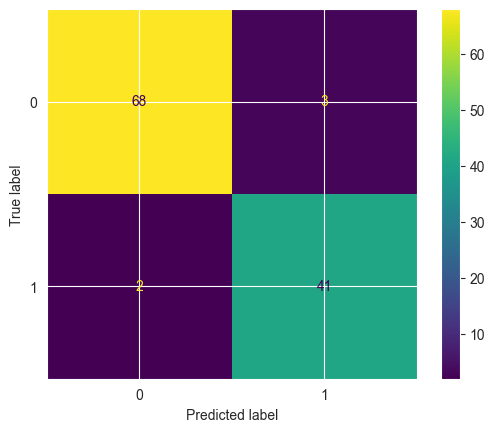

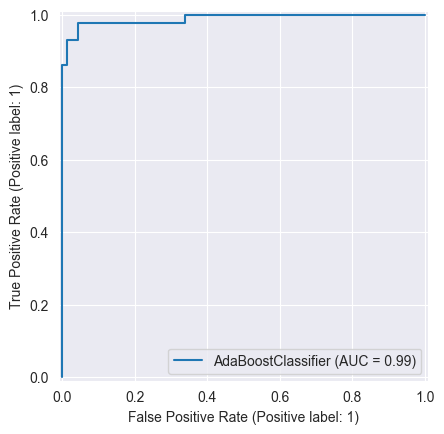

In [32]:
adaboost = AdaBoostClassifier(random_state = SEED)
adaboost.fit(X_train_2, y_train)
y_pred_test = adaboost.predict(X_test_2)

print(f'Classification Report:\n{classification_report(y_test, y_pred_test)}')
print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_pred_test)
print(ConfusionMatrixDisplay(confusion_matrix = cm).plot())

RocCurveDisplay.from_estimator(adaboost, X_test_2, y_test)

Axes(0.125,0.11;0.775x0.77)


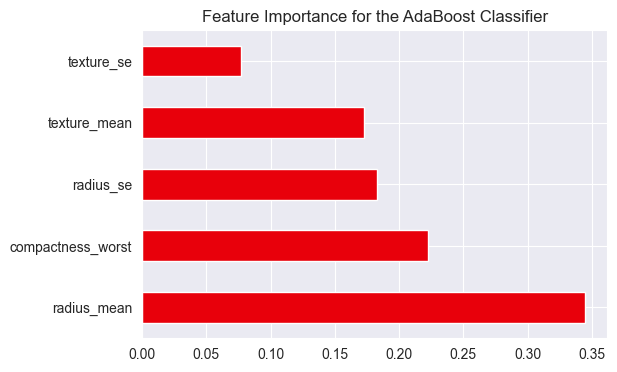

In [33]:
print(pd.Series(adaboost.feature_importances_,
                index = X_train_2.columns).
      sort_values(ascending = False).
      plot(kind = 'barh',
           figsize = (6, 4),
           color = palette[3],
           title = 'Feature Importance for the AdaBoost Classifier', ))